<center>
    <h1>Fruit Inspection</h1>
    <h2>Image Processing and Computer Vision</h2>
    <h3>Facundo Nicolas Maidana and Riccardo Spolaor</h3>
    <h4>facundo.maidana@studio.unibo.it; riccardo.spolaor@studio.unibo.it</h4>
</center>

---

This notebook presents the development of a system aimed at locating defects and imperfection in fruits. Each fruit is acquired through a NIR *(Near Infra-Red)* and color camera that present little parallax effect among each other.

<table>
    <tr>
        <td><img src="images/first task/C0_000001.png" width="200"/></td>
        <td><img src="images/first task/C1_000001.png" width="200"/></td>
    </tr>
    <tr>
        <td style='text-align:left'>NIR example</td>
        <td style='text-align:left'>Color example</td>
    </tr>
</table>

# 00 Prerequisites
The libraries necessary for the task are imported.

In [1]:
%matplotlib inline

import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
from time import time

# Utils libraries
from graphics import *
from utils import *

The cell below illustrates the version of `OpenCV` used for the task.

In [2]:
print(f'Using OpenCV version: {cv2.__version__}.')

Using OpenCV version: 4.6.0.


The random seed is set for both the `numpy` and `OpenCV` libraries in order to guarantee reproducibility of results.

In [3]:
SEED = 42

cv2.setRNGSeed(SEED)
np.random.seed(SEED)

# 01 First task: Fruit Segmentation and Defect Detection
The first task considers the images in the folder `images/first task/`, that present apples with external defects which are clearly visible.

In order to localize these defects two steps have to be carried out:
- Each fruit should be outlined by means of a binary mask that separates the foreground (the fruit) from the background. This step is performed through a tresholding technique;
- A search to identify the defects on the fruit must be carried out on the outlined portion of the image.

*Note: given the fact that NIR and color images have little parallax, a mask can be computed on one and applied to the other.*

## 01.1 Image analysis 
The series of images is firstly imported and plotted.

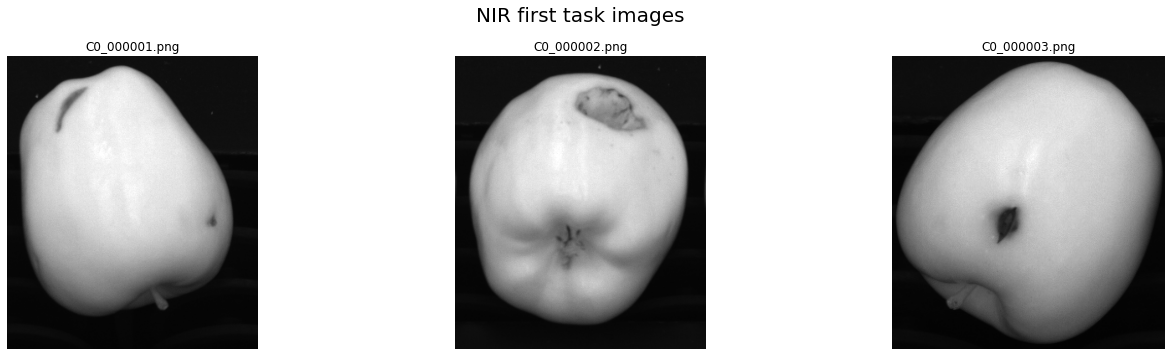

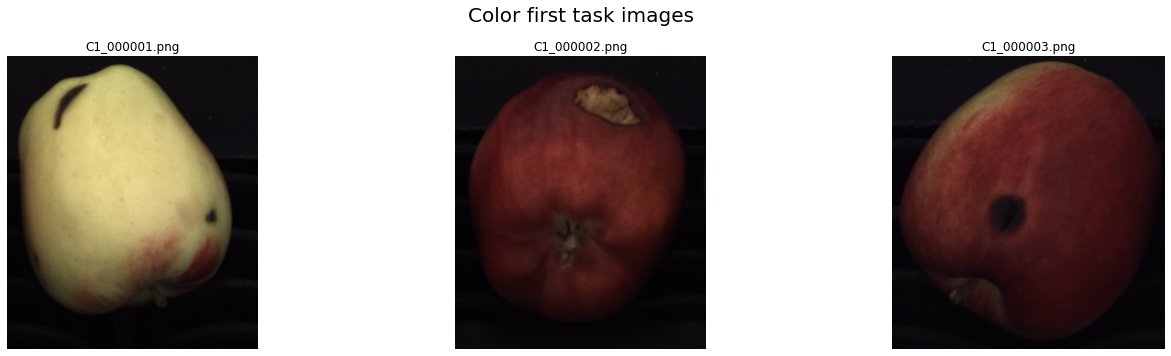

In [4]:
# Create two arrays containing the names of the NIR and color images respectively
nir_names, color_names = [[f'C{j}_00000{i}.png' for i in range(1,4)] for j in [0,1]]

# Directory where the images are saved
DIR = 'images/first task/'

# Import NIR and color images
nir_imgs = [cv2.imread(f'{DIR}{img}', cv2.IMREAD_GRAYSCALE) for img in nir_names]
color_imgs = [cv2.imread(f'{DIR}{img}') for img in color_names]

# Plot the NIR and color images
plot_image_grid(nir_imgs, 'NIR first task images', nir_names)
plot_image_grid(color_imgs, 'Color first task images', color_names)

Next, the *gray-level histograms* of the three NIR images are computed and shown.

By observing the results we can identify a greater concentration of pixels around the interval $[0, 25]$, which should correspond to background pixels. Moreover, other small peaks are present around higher values for the gray levels, which should represent foreground pixels belonging to the fruit. 

Unfortunately, the distribution of background and foreground pixels is slightly different among the three images. Furthermore the istograms are not clearly *bimodal* and an actual treshold that binarizes the image cannot be trivially identified. It can be observed that image `C0_000003.png` presents an even more confusing separation among background and foreground pixels.

These outcomes should be expected since the NIR images shown above are not *inherently binary*. The shadowy areas due to the lighting variations and the presence of the defects and textures on the fruit are the main reasons of the lack of bimodality in the histogram.

Furthermore, sources of noise may be another impacting factor, in fact, some of the tresholding algorithms presented in the next section consider image preprocessing.

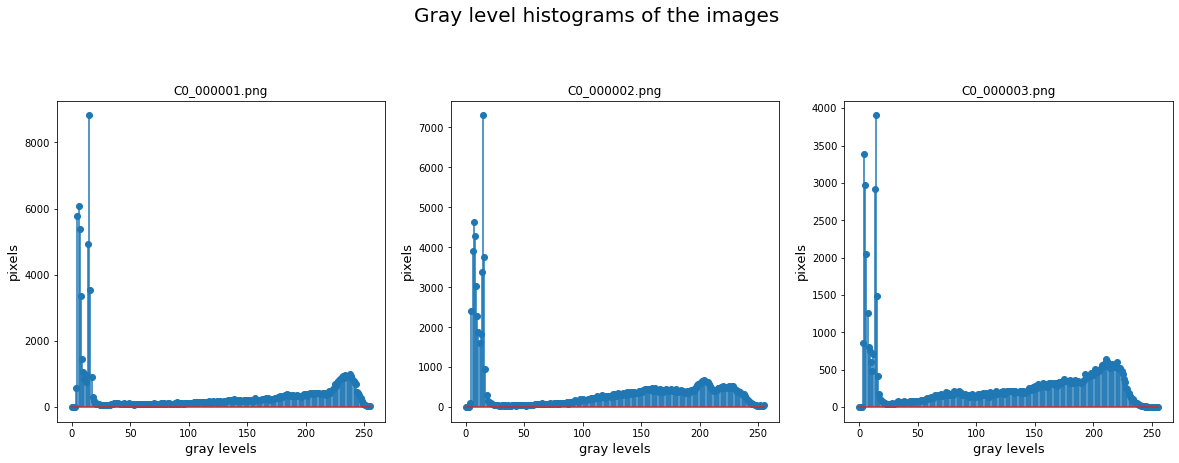

In [5]:
plot_histogram_grid(nir_imgs, 'Gray level histograms of the images', nir_names)

In [6]:
# TODO: Decide whether to show preprocessing or not

In [7]:
'''s = time()
SIGMA = 2
K = math.ceil(3*SIGMA)
gaussian_blur_imgs = [cv2.GaussianBlur(img, (2*K+1, 2*K+1), SIGMA) for img in nir_imgs]
gaussian_blur_time = time() - s

s = time()
median_blur_imgs = [cv2.medianBlur(img, 5) for img in nir_imgs]
median_blur_time = time() - s

s = time()
bilateral_imgs = [cv2.bilateralFilter(img, d = 5, sigmaColor = 10, sigmaSpace = 3) for img in nir_imgs]
bilateral_time = time() - s
''';

In [8]:
'''plot_image_grid(gaussian_blur_imgs, 'Gaussian blurred images', nir_names)
plot_image_grid(median_blur_imgs, 'Median blurred images', color_names)''';

In [9]:
'''plt.bar(['gaussian blur time', 'median blur time', 'bilateral filter time'], 
        [gaussian_blur_time, median_blur_time, bilateral_time])
plt.show()''';

In [10]:
'''plot_histogram_grid(gaussian_blur_imgs, 'Gray level histograms of the Gaussian Blurred images', nir_names)
plot_histogram_grid(median_blur_imgs, 'Gray level histograms of the Median Blurred images', nir_names)''';

## 01.2 Outline the fruit by generating a binary mask
In order to compute the binary mask that outlines the fruit image segmentation through binary tresholding is applied.

In particular, four different methods are taken into consideration and compared in terms of time performances and quality of the output. Different preprocessing approaches are considered to guarantee accurate results are obtained.

The considered techniques are:
- *Binarization by Intensity Thresholding*;
- *Otsu's Algorithm*;
- *Triangle Algorithm*;
- *Adaptive Thresholding*.

### 01.2.1 Preprocessing noise
In order to guarantee better performances during the binarization tasks a pre-processing operation has been applied to the images to remove unwanted noisy signals.

More specifically, a combination of a *Median blur* filter followed by a *Gaussian Blur* one seemed to be the best combination to obtain better segmentation results. Median filters impulse signal elimination is effective when followed by other liner filters in order to remove gaussian noise.

The following pipeline is though followed for preprocessing:
- A Median Blur filter using a $(3 \times 3)$ kernel is applied to the image to remove possible impulse signal;
- A Gaussian Blur filter is applied to the image to remove unwanted Gaussian Noise and to blur the image. The filter used a $\sigma$ value of $2$ and a kernel of dimension $(2 \cdot k + 1, 2 \cdot k + 1)$, where $k$ is computed through a *rule-of-thumb* as $k = \left \lceil 3 \cdot \sigma \right \rceil$.

The time to compute these operations is $\approx 0.002$ seconds for the three images.

Time required for the filtering operations: 0.002001 s


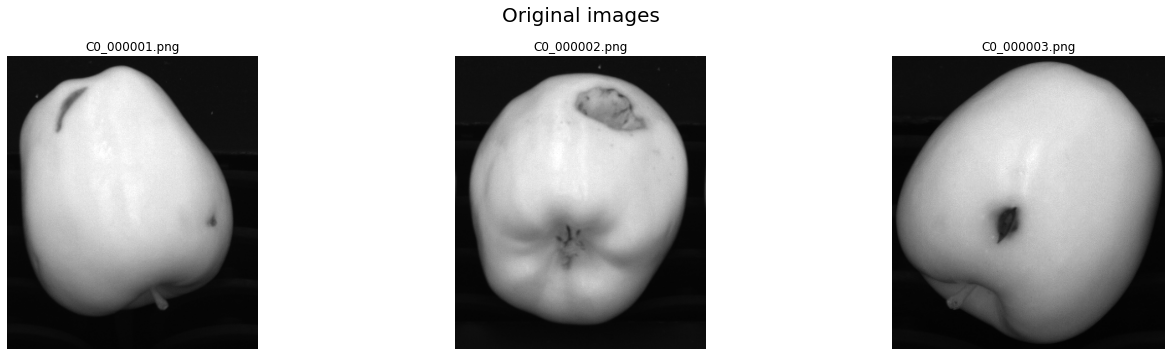

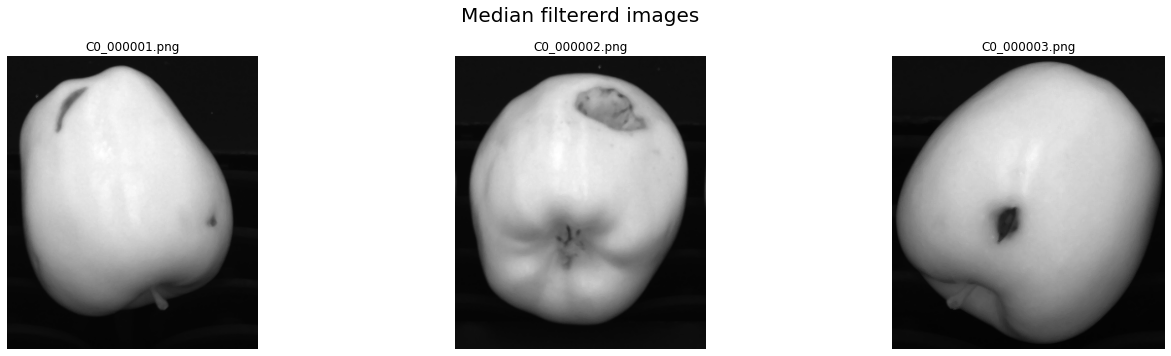

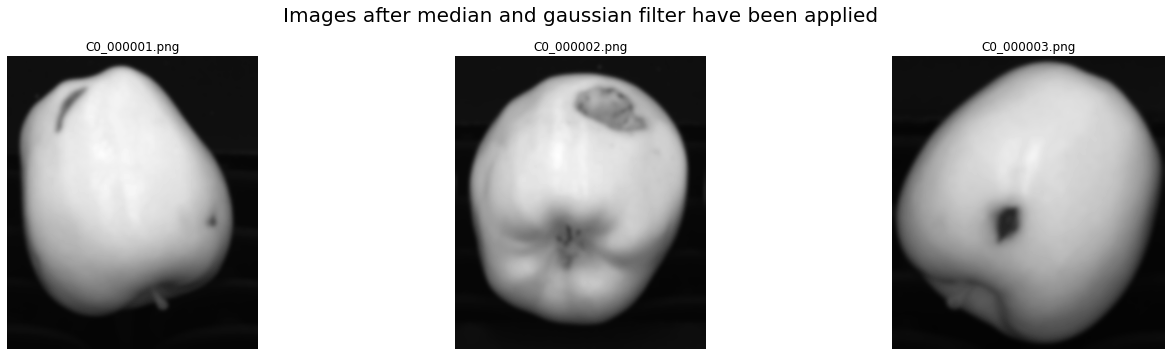

In [11]:
SIGMA = 2
K = math.ceil(3*SIGMA)

start_time = time()

median_filtered_images = [cv2.medianBlur(img, 3) for img in nir_imgs]
filtered_images = [cv2.GaussianBlur(img, (2*K+1, 2*K+1), SIGMA) for img in median_filtered_images]

print(f'Time required for the filtering operations: {time() - start_time:.4} s')

# Plot the NIR and color images
plot_image_grid(nir_imgs, 'Original images', nir_names)
plot_image_grid(median_filtered_images, 'Median filtererd images', nir_names)
plot_image_grid(filtered_images, 'Images after median and gaussian filter have been applied', nir_names)

### 01.2.2 Binarization by Intensity Tresholding
This first approach is the simplest and faster. A global treshold $t$ is manually provided in order to binarize the image $I$ by transforming each of its pixels $(i,j)$, such that:

$$\forall i,j, \ I(i,j) = 
\begin{cases} 
    0, & \text{if} \ I(i,j) \leq t \\
    255, & \text{otherwise}
\end{cases}$$

Where $0$ corresponds to background pixels and $255$ to foreground pixels.

As previously explained, finding such treshold is not trivial given that the gray-level histogram is not bimodal.
Various experiments have shown that a good value of this treshold that guarantees a good binarization is found in the range $[20-30]$ after a *Gaussian smoothing* filter has been applied to remove noisy signals.

The gaussian filter has

The used filter 

0.0019986629486083984


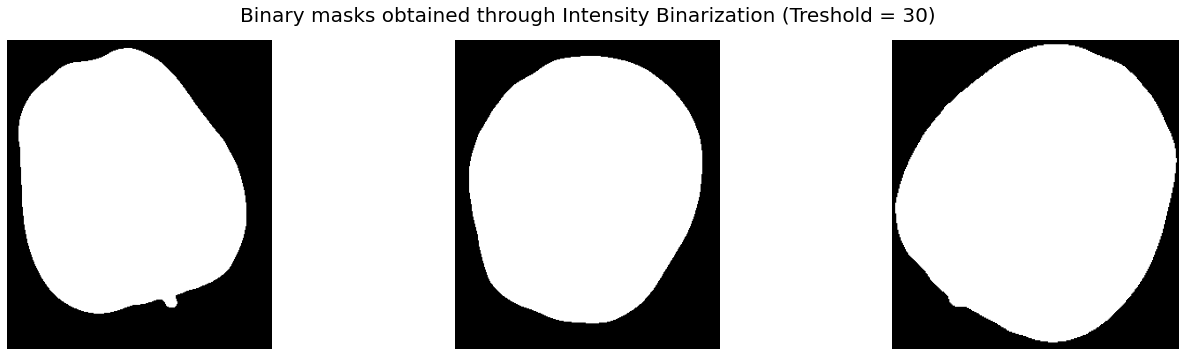

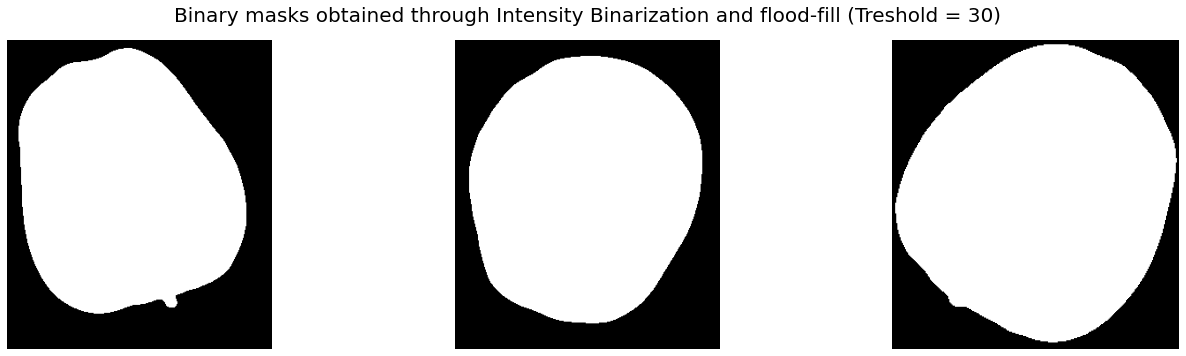

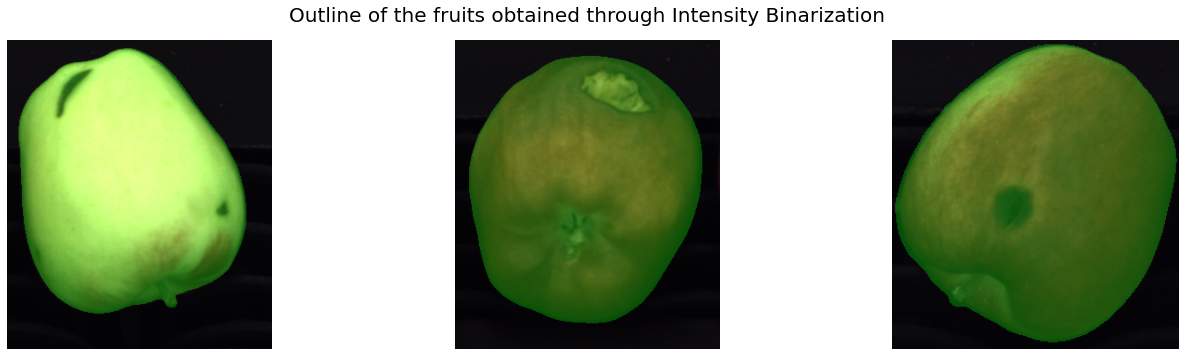

In [12]:
# Set the treshold for image segmentation
MANUAL_TRESHOLD = 30

masks = []

# Set
SIGMA = 2
K = math.ceil(3*SIGMA)

s = time()

for img in nir_imgs:
    blur = cv2.medianBlur(img, 3)
    blur = cv2.GaussianBlur(blur, (2*K+1, 2*K+1), SIGMA)
    treshold, mask = cv2.threshold(blur, MANUAL_TRESHOLD, 255, cv2.THRESH_BINARY)
    masks.append(mask)

print(time() - s)

plot_image_grid(masks, f'Binary masks obtained through Intensity Binarization (Treshold = {MANUAL_TRESHOLD})')

masks = [apply_flood_fill(i) for i in masks]

plot_image_grid(masks, f'Binary masks obtained through Intensity Binarization and flood-fill (Treshold = {MANUAL_TRESHOLD})')

bounded_images = []

for idx, img in enumerate(color_imgs):
    green_mask = cv2.cvtColor(masks[idx], cv2.COLOR_GRAY2BGR)
    # Force the bits of every channel except the green at 0
    green_mask[:,:,::2] = 0
    bounded_images.append(cv2.addWeighted(green_mask, 0.3, img, 1, 0))
    
plot_image_grid(bounded_images, 'Outline of the fruits obtained through Intensity Binarization')

In [13]:
'''# TODO Parametrize
# this is just for visualization.
# By looking at the greyscale histogram it is evident that the image is not inherently binary 
# and a clear threshold dividing background and foreground + imperfercions can't be found manually.
MANUAL_TRESHOLD = 25
s = time()
masks = [cv2.threshold(i, MANUAL_TRESHOLD, 255, cv2.THRESH_BINARY)[1] for i in nir_imgs]
print(time() - s)
plot_image_grid(masks, f'Binary masks obtained through Intensity Binarization (Treshold = {MANUAL_TRESHOLD})')

masks = [apply_flood_fill(i) for i in masks]

plot_image_grid(masks, f'Binary masks obtained through Intensity Binarization and flood-fill (Treshold = {MANUAL_TRESHOLD})')

bounded_images = []

for idx, img in enumerate(color_imgs):
    green_mask = cv2.cvtColor(masks[idx], cv2.COLOR_GRAY2BGR)
    # Force the bits of every channel except the green at 0
    green_mask[:,:,::2] = 0
    bounded_images.append(cv2.addWeighted(green_mask, 0.3, img, 1, 0))
    
plot_image_grid(bounded_images, 'Outline of the fruits obtained through Intensity Binarization')''';

0.0010013580322265625


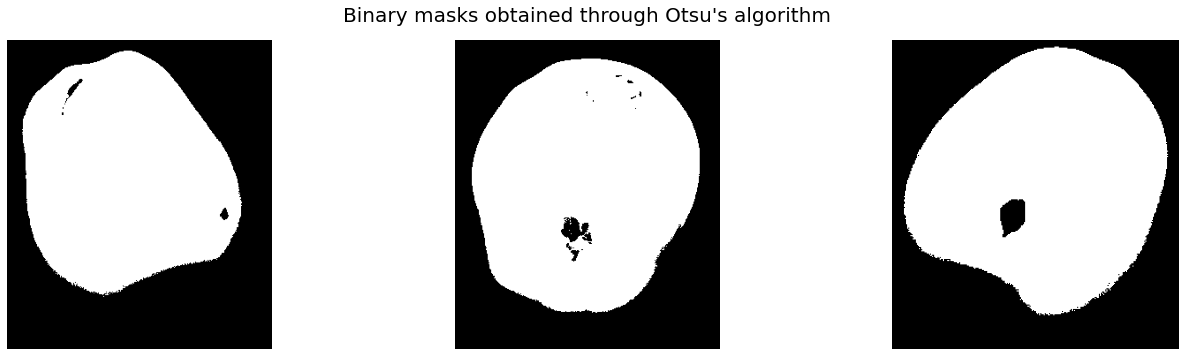

Tresholds obtained for each image: [109.0, 98.0, 104.0]


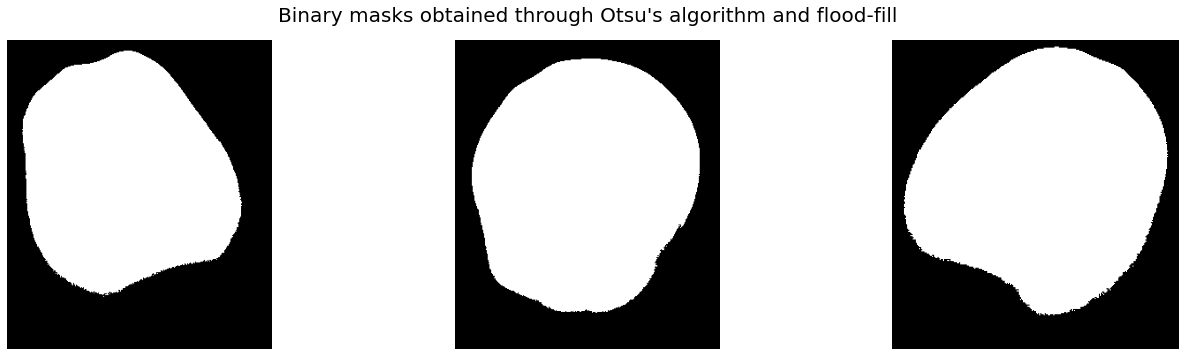

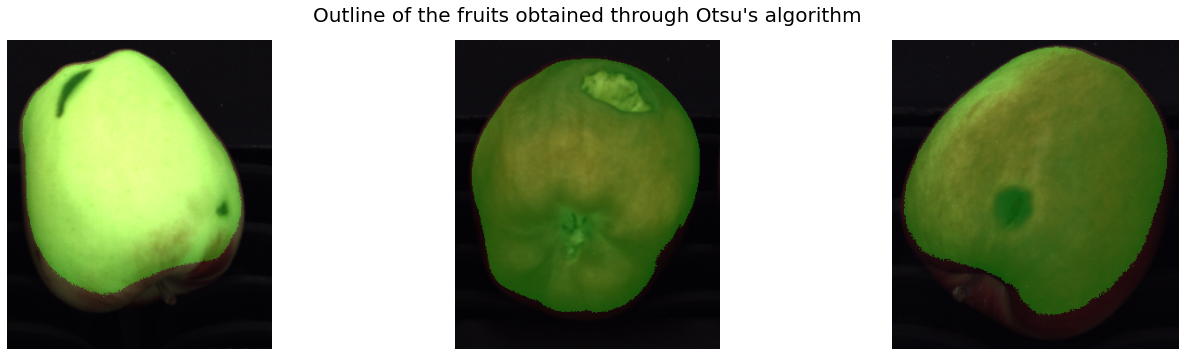

In [14]:
masks = []
tresholds = []

s = time()
for img in nir_imgs:
    treshold, mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    masks.append(mask)
    tresholds.append(treshold)
print(time() - s)

plot_image_grid(masks, f'Binary masks obtained through Otsu\'s algorithm')

print(f'Tresholds obtained for each image: {tresholds}')

masks = [apply_flood_fill(i) for i in masks]

plot_image_grid(masks, 'Binary masks obtained through Otsu\'s algorithm and flood-fill')

bounded_images = []

for idx, img in enumerate(color_imgs):
    green_mask = cv2.cvtColor(masks[idx], cv2.COLOR_GRAY2BGR)
    # Force the bits of every channel except the green at 0
    green_mask[:,:,::2] = 0
    bounded_images.append(cv2.addWeighted(green_mask, 0.3, img, 1, 0))
    
plot_image_grid(bounded_images, 'Outline of the fruits obtained through Otsu\'s algorithm')

0.001997232437133789


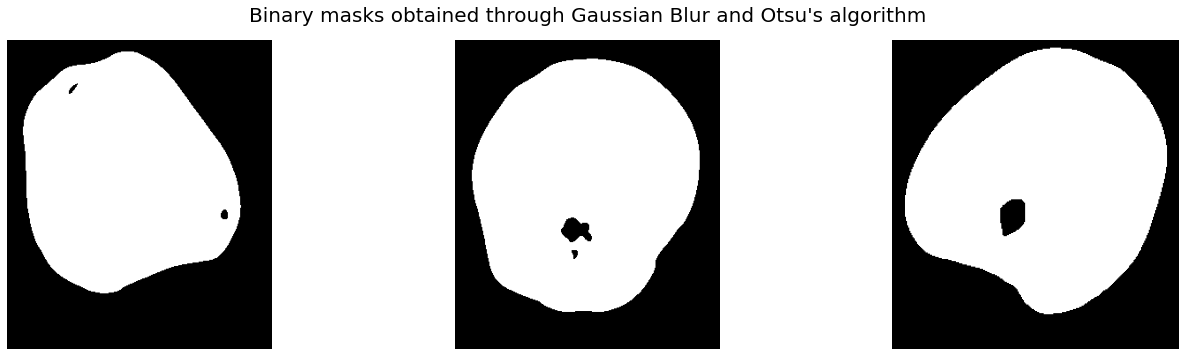

Tresholds obtained for each image: [110.0, 98.0, 105.0]


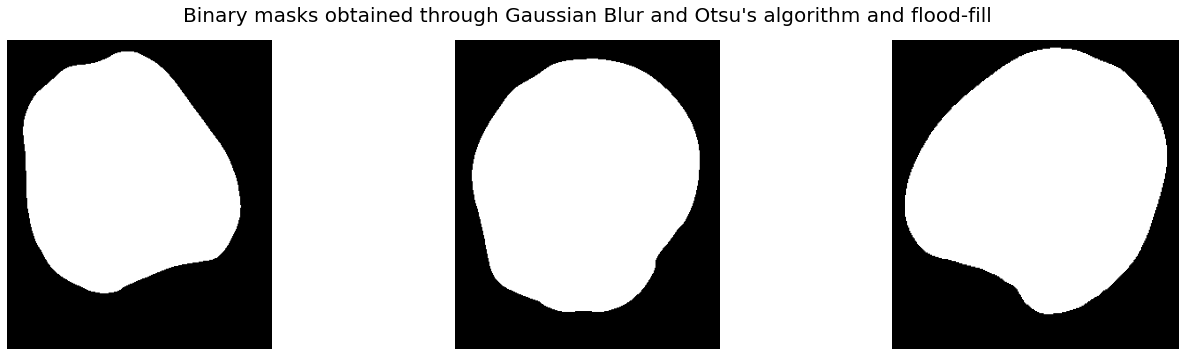

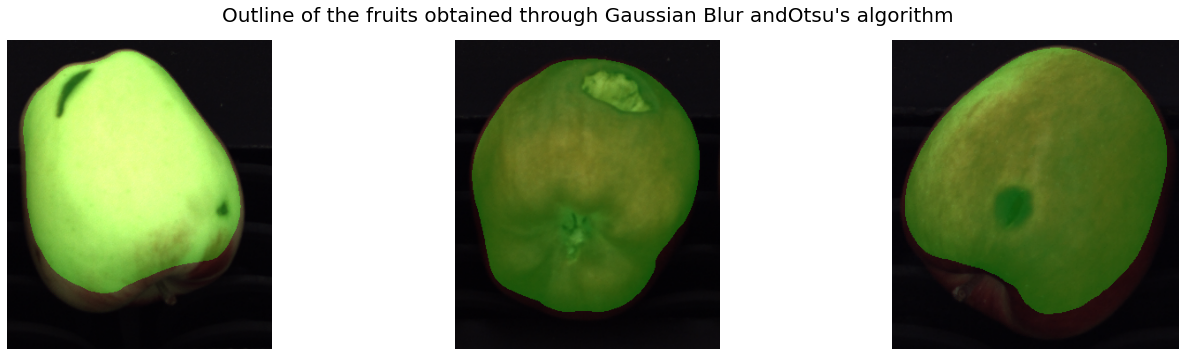

In [15]:
masks = []
tresholds = []

s = time()
for img in nir_imgs:
    sigma=2
    k = math.ceil(3*sigma)
    blur = cv2.medianBlur(img, 3)
    blur = cv2.GaussianBlur(blur, (2*k+1, 2*k+1), sigma)
    #blur = cv2.medianBlur(img, 15)
    treshold, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    masks.append(mask)
    tresholds.append(treshold)
print(time() - s)
    
plot_image_grid(masks, f'Binary masks obtained through Gaussian Blur and Otsu\'s algorithm')

print(f'Tresholds obtained for each image: {tresholds}')

masks = [apply_flood_fill(i) for i in masks]

plot_image_grid(masks, 'Binary masks obtained through Gaussian Blur and Otsu\'s algorithm and flood-fill')

bounded_images = []

for idx, img in enumerate(color_imgs):
    green_mask = cv2.cvtColor(masks[idx], cv2.COLOR_GRAY2BGR)
    # Force the bits of every channel except the green at 0
    green_mask[:,:,::2] = 0
    bounded_images.append(cv2.addWeighted(green_mask, 0.3, img, 1, 0))
    
plot_image_grid(bounded_images, 'Outline of the fruits obtained through Gaussian Blur andOtsu\'s algorithm')

0.014002561569213867


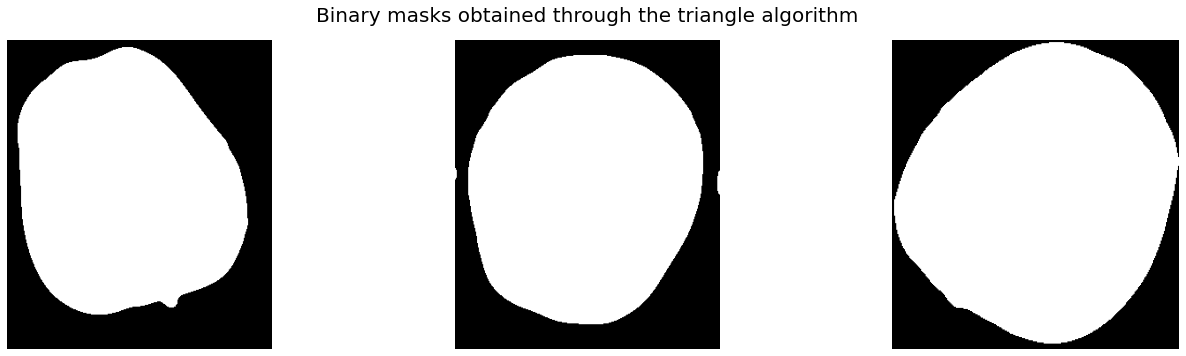

Tresholds obtained for each image: [20.0, 19.0, 19.0]


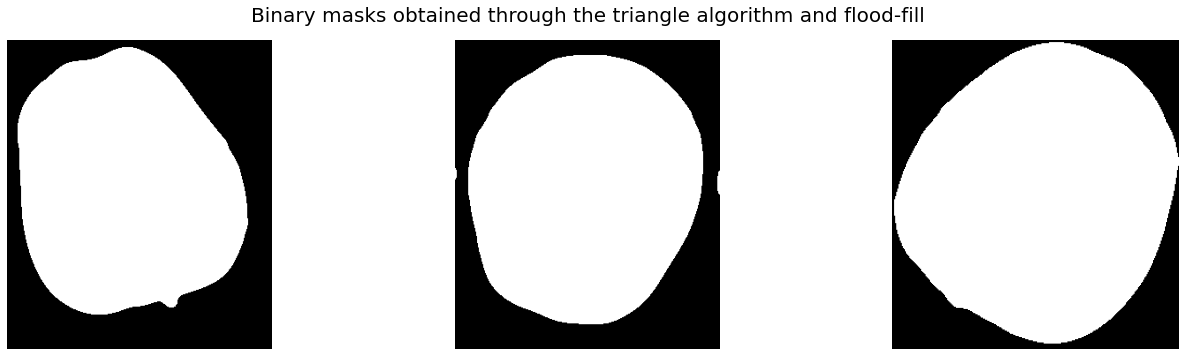

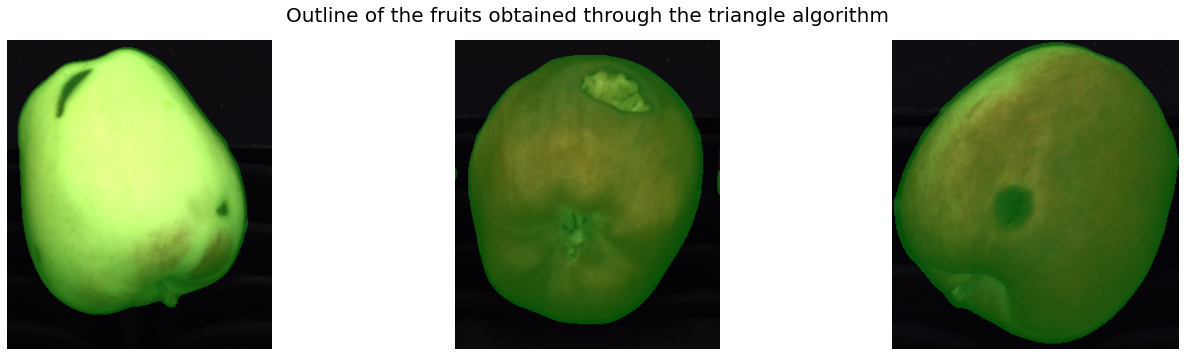

In [16]:
masks = []
tresholds = []

s = time()
for img in nir_imgs:
    sigma = 2
    k = math.ceil(3*sigma)
    blur = cv2.medianBlur(img, 11)
    blur = cv2.GaussianBlur(blur, (2*k+1, 2*k+1), sigma)
    #blur = cv2.bilateralFilter(blur, d = 7, sigmaColor = 10, sigmaSpace = 3)
    treshold, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_TRIANGLE)
    masks.append(mask)
    tresholds.append(treshold)
print(time() - s)
    
plot_image_grid(masks, f'Binary masks obtained through the triangle algorithm')

print(f'Tresholds obtained for each image: {tresholds}')

masks = [apply_flood_fill(i) for i in masks]

plot_image_grid(masks, 'Binary masks obtained through the triangle algorithm and flood-fill')

bounded_images = []

for idx, img in enumerate(color_imgs):
    green_mask = cv2.cvtColor(masks[idx], cv2.COLOR_GRAY2BGR)
    # Force the bits of every channel except the green at 0
    green_mask[:,:,::2] = 0
    bounded_images.append(cv2.addWeighted(green_mask, 0.3, img, 1, 0))
    
plot_image_grid(bounded_images, 'Outline of the fruits obtained through the triangle algorithm')

0.0030336380004882812


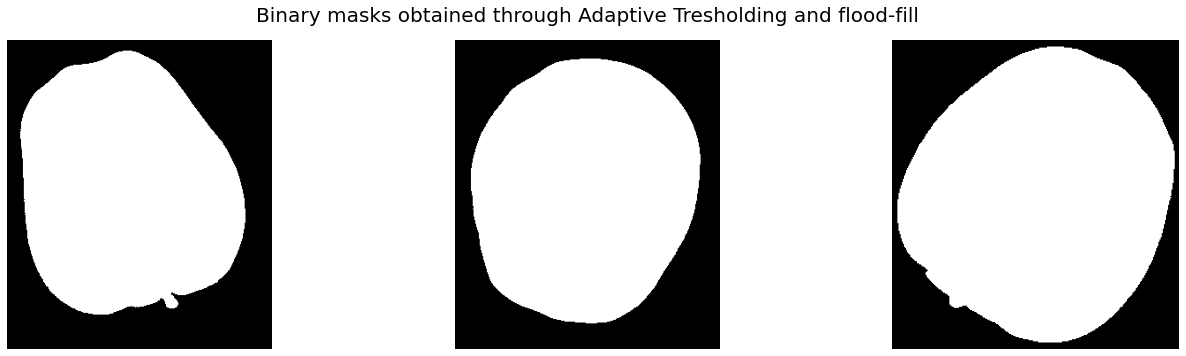

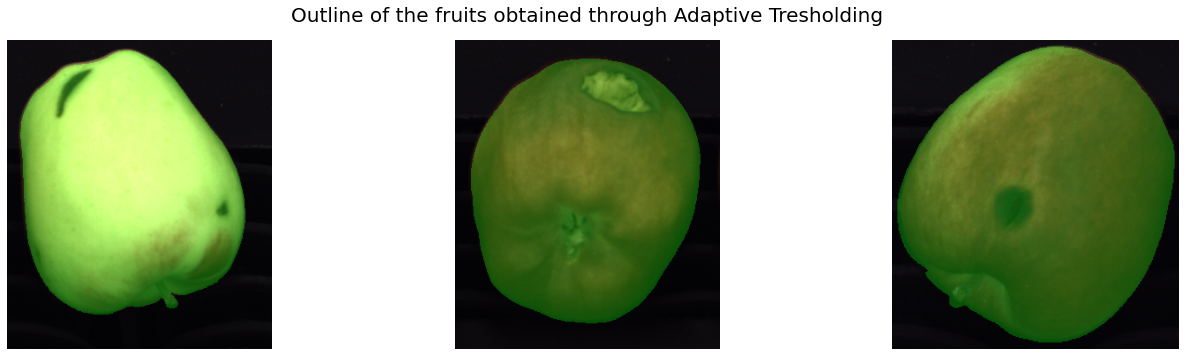

In [17]:
masks = []

s = time()
for img in nir_imgs:
    #sigma = 5
    #k = math.ceil(3*sigma)
    blur = cv2.medianBlur(img, 3)
    blur = cv2.GaussianBlur(blur, (2*k+1, 2*k+1), sigma)
    #img_blur = cv2.medianBlur(img, 5)
    mask = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 3)
    masks.append(mask)

#plot_image_grid(masks, 'Binary masks obtained through Adaptive Tresholding')

# Pad masks and flood-fill the background
masks = [np.pad(m, 1, mode='constant', constant_values=255) for m in masks]
for m in masks:
    cv2.floodFill(m, None, (0,0), 0)
# Downsample the masks to their original size
masks = [m[1:-1,1:-1] for m in masks]
print(time() - s)

masks = [apply_flood_fill(i) for i in masks]

plot_image_grid(masks, 'Binary masks obtained through Adaptive Tresholding and flood-fill')

bounded_images = []

for idx, img in enumerate(color_imgs):
    green_mask = cv2.cvtColor(masks[idx], cv2.COLOR_GRAY2BGR)
    # Force the bits of every channel except the green at 0
    green_mask[:,:,::2] = 0
    bounded_images.append(cv2.addWeighted(green_mask, 0.3, img, 1, 0))
    
plot_image_grid(bounded_images, 'Outline of the fruits obtained through Adaptive Tresholding')

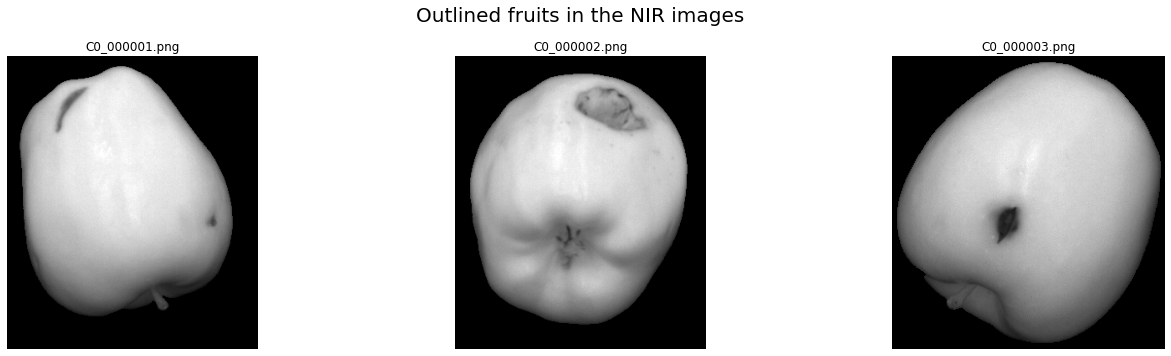

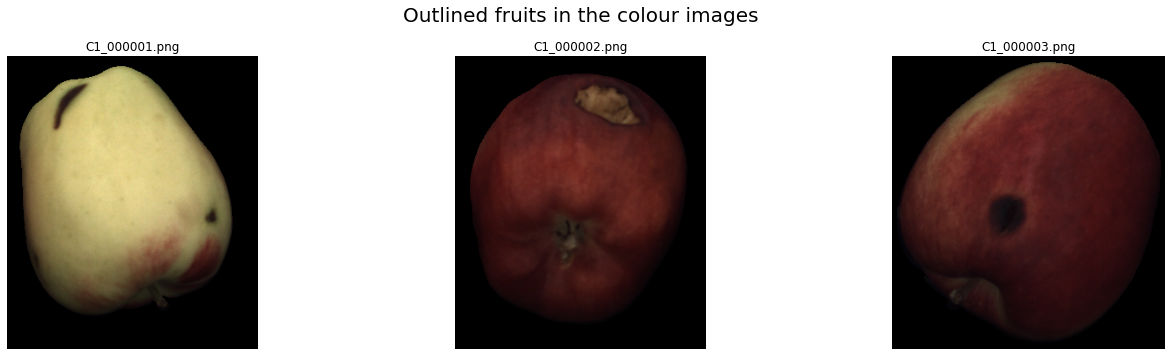

In [18]:
masked_nir_imags = [nir_imgs[i] & masks[i] for i in range(len(masks))]
masked_colour_imgs = [color_imgs[i] &  cv2.cvtColor(masks[i], cv2.COLOR_GRAY2BGR) for i in range(len(masks))]

plot_image_grid(masked_nir_imags, 'Outlined fruits in the NIR images', nir_names)
plot_image_grid(masked_colour_imgs, 'Outlined fruits in the colour images', color_names)

# TODO
### HISTOGRAM EQ TEST

In [19]:
'''def stretch_img(img):
    def linear_stretching(img, max_value, min_value):
        img[img<min_value] = min_value
        img[img>max_value] = max_value
        linear_stretched_img = 255./(max_value-min_value)*(img-min_value)
        return linear_stretched_img

    def find_percentile_value(hist, percentile):
        s = 0
        idx = 0
        total_pixel = np.sum(hist)
        while(s < total_pixel*percentile/100):
            s += hist[idx]
            idx += 1
        return idx

    max_value = find_percentile_value(hist, 60)
    min_value = find_percentile_value(hist, 5)
    print("Max 95%: ", max_value, " Min 5%: ", min_value)
    linear_stretched_img=linear_stretching(np.copy(img), max_value,min_value)
    
    return linear_stretched_img.astype(np.uint8)''';

In [20]:
'''sigma=3
k = math.ceil(3*sigma)
imgs_equalized = [stretch_img(cv2.GaussianBlur(img, (2*k+1, 2*k+1), sigma)) for img in grayscale_imgs_1]
plot_image_grid(grayscale_imgs_1, 
                'Original Images', 
                show_axis=False)

fig = plt.figure(figsize=(20,13))
fig.suptitle('Gray level histogram of the images', fontsize=20)
for idx, img in enumerate(grayscale_imgs_1):
    plt.subplot(2, 3, idx+1)
    hist, _ = np.histogram(img.flatten(), 256, [0,256])
    plt.stem(hist, use_line_collection=True)
plt.tight_layout()
plt.show()

plot_image_grid(imgs_equalized, 
                'Equalized Images', 
                show_axis=False)

fig = plt.figure(figsize=(20,13))
fig.suptitle('Gray level histogram of the images', fontsize=20)
for idx, img in enumerate(imgs_equalized):
    plt.subplot(2, 3, idx+1)
    hist, _ = np.histogram(img.flatten(), 256, [0,256])
    plt.stem(hist, use_line_collection=True)
plt.tight_layout()
plt.show()''';

In [21]:
'''masks = []
tresholds = []

print(imgs_equalized[0])

for img in imgs_equalized:
    sigma=1
    k = math.ceil(3*sigma)
    blur = img
    blur = cv2.GaussianBlur(img, (2*k+1, 2*k+1), sigma)
    treshold, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    masks.append(mask)
    tresholds.append(treshold)

plot_image_grid(masks, 
                f'Binary masks obtained through Gaussian Blur and Otsu\'s algorithm', 
                show_axis=False)

print(f'Tresholds obtained for each image: {tresholds}')

masks = [apply_flood_fill(i) for i in masks]

plot_image_grid(masks, 
                'Binary masks obtained through Gaussian Blur and Otsu\'s algorithm and flood-fill', 
                show_axis=False)

bounded_images = []

for idx, img in enumerate(color_imgs_1):
    green_mask = cv2.cvtColor(masks[idx], cv2.COLOR_GRAY2BGR)
    # Force the bits of every channel except the green at 0
    green_mask[:,:,::2] = 0
    bounded_images.append(cv2.addWeighted(green_mask, 0.3, img, 1, 0))
    
plot_image_grid(bounded_images, 
                'Outline of the fruits obtained through Gaussian Blur andOtsu\'s algorithm', 
                show_axis=False)''';

In [22]:
'''# this is just for visualization.
# By looking at the greyscale histogram it is evident that the image is not inherently binary 
# and a clear threshold dividing background and foreground + imperfercions can't be found manually.
ret, mask = cv2.threshold(img,100,255,cv2.THRESH_BINARY)
fig = plt.figure(figsize=(15,13))
# plt.imshow(cv2.cvtColor(img_clr, cv2.COLOR_BGR2RGB))
plt.imshow(mask, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

#print(f'The obtained threshold with Intensity Binarization is {ret}')''';

In [23]:
"""ret, mask = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# plt.imshow(cv2.cvtColor(img_clr, cv2.COLOR_BGR2RGB))
plt.imshow(threshold, cmap='gray', vmin=0, vmax=255)
plt.show()

print(f'The obtained threshold with Otsu\'s Algorithm is {ret}')

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img,(5,5),0)
ret,threshold = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(cv2.cvtColor(img_clr, cv2.COLOR_BGR2RGB))
plt.imshow(threshold, cmap='gray', vmin=0, vmax=255, alpha=0.2)
plt.show()

print(f'The obtained threshold with Otsu\'s Algorithm + Gaussian Smoothing is {ret}')""";

In [24]:
'''img_blur = cv2.medianBlur(grayscale_imgs_1[0], 25)
threshold = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 5)

#plt.imshow(cv2.cvtColor(img_clr, cv2.COLOR_BGR2RGB))
plt.imshow(threshold, cmap='gray', vmin=0, vmax=255)
plt.show()''';